In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all words
words = open("../lec1_intro_language_modeling/names.txt").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {s:i for i,s in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
# training split (used to train parameters), dev/validation split (used to train hyperparameters), test split
# 80%, 10%, 10%
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one ?
def build_dataset(words):
        
    X, Y = [], []
    for w in words:
        
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '----->', itos[ix])
            context = context[1:] + [ix] # crop and append . Ruling window
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [8]:
n_embd = 10
n_hidden = 200 # the  number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # to include determinism
C = torch.randn((vocab_size,n_embd), generator=g) # matrix of embeddings initialized randomly
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) # 2-dim embedding * 3 context length
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [9]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)  # PyTorch will infer the correct missing dimension
    hpreact = embcat  @ W1 + b1 # hidden layer pre-activation 
    h = torch.tanh(hpreact) # hidden layer  
    logits = h @ W2 + b2 # outputs layer
    # counts = logits.exp()   # The next 3 lines are called Cross-entropy
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track state
    # lri.append(lre[i])
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 25.5262
  10000/ 200000: 1.8812
  20000/ 200000: 2.2138
  30000/ 200000: 2.4113
  40000/ 200000: 2.7117
  50000/ 200000: 2.0645
  60000/ 200000: 2.7141
  70000/ 200000: 2.4444
  80000/ 200000: 1.9884
  90000/ 200000: 2.4939
 100000/ 200000: 2.1920
 110000/ 200000: 2.1292
 120000/ 200000: 2.0278
 130000/ 200000: 1.8125
 140000/ 200000: 2.4966
 150000/ 200000: 2.2963
 160000/ 200000: 2.0371
 170000/ 200000: 2.0863
 180000/ 200000: 2.5699
 190000/ 200000: 1.8471


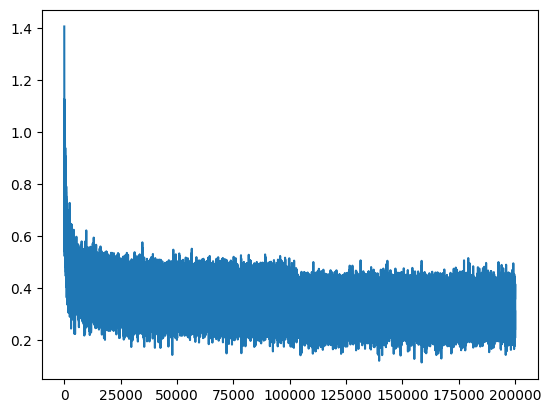

In [10]:
plt.plot(lossi)

In [12]:
@torch.no_grad() # this decorator diables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
    

train 2.122389078140259
val 2.184129238128662


In [13]:
# sample from the model 
g = torch.Generator().manual_seed(2147483647 + 10) # to include determinism

for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        # forward pass neural net
        emb = C[torch.tensor(context)] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the sample
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special token '.' break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

mora.
kayah.
seel.
nihayla.
rethruthndrari.
adejadieliigh.
piren.
eden.
vananar.
katelle.
kalin.
shravri.
hiriel.
kindreelleranthuon.
ubrence.
ryyah.
fael.
yuma.
mis.
kyra.
